## Data Science Regression Project: Predicting Home Prices in Banglore

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

### Data Load: Load banglore home prices into a dataframe

In [2]:
df = pd.read_csv("house_prices.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

In [4]:
# Calling out all the unique values in the area_type

df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [5]:
# count of the number of occurances of each values in the area_type column

df['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

In [6]:
# Drop features that are not required to build our model

df = df.drop(['area_type','society','balcony','availability'],axis='columns')
df.shape

(13320, 5)

## Data Cleaning: Handle NA values

In [7]:
# Number of missing values in each column

df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
# filling missing values in column "bath" with the mode

df['bath'].fillna((df['bath'].mode()[0]), inplace=True)

In [9]:
# Droping all the missing values in each column

df = df.dropna()

# checking if there are still missing values
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

## Feature Engineering

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [10]:
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [11]:
# extracting the number of rooms attached to the size column

df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

**Explore total_sqft feature**

In [12]:
# This function checks and convert the values in a column are floats

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [13]:
# Apply the float check function to the total_sqft column and negate (~) it.

df[~df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
224,Devanahalli,3 BHK,1520 - 1740,2.0,74.820,3
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [14]:
# This function splits the values in the total_sqft, add it together and divid by 2 to find the average

def convert_sqft_to_num(x):
    tokens = x.split('-') # splitting by '-'
    if len(tokens) == 2: 
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [15]:
# apply the convert function to the total_sqft
df.total_sqft = df.total_sqft.apply(convert_sqft_to_num)
# getting only the not nulls
df = df[df.total_sqft.notnull()]
df.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


**For below row, it shows that the areas where the square feet is in a range, has been converted to its average**

## Feature Engineering

**Add new feature called price per square feet**

In [16]:
# Adding a new column 'price_per_sqft' for processing

df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [17]:
# getting the statistical values price per sqft column
df_stats = df['price_per_sqft'].describe()
df_stats

count    1.325700e+04
mean     7.912825e+03
std      1.064976e+05
min      2.678298e+02
25%      4.271186e+03
50%      5.438596e+03
75%      7.313318e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [18]:
# saving the dataset into a new csv
df.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [20]:
# striping/removing all empty spaces in the location 

df['location'] = df['location'].apply(lambda x: x.strip())

# value count of each unique value
location_stats = df['location'].value_counts(ascending=False)
location_stats

location
Whitefield                   538
Sarjapur  Road               397
Electronic City              304
Kanakpura Road               271
Thanisandra                  236
                            ... 
Nagarbhavi  BDA Complex        1
Rajanna Layout                 1
1 Ramamurthy Nagar             1
Lakshmipura Vidyaanyapura      1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [24]:
len(location_stats[location_stats<=10])

1047

## Dimensionality Reduction

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [25]:
# assigning the locations that are less than 10 into a variable

location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Sadashiva Nagar              10
BTM 1st Stage                10
Nagadevanahalli              10
Sector 1 HSR Layout          10
Basapura                     10
                             ..
Nagarbhavi  BDA Complex       1
Rajanna Layout                1
1 Ramamurthy Nagar            1
Lakshmipura Vidyaanyapura     1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64

In [27]:
# all values with count less than 10 will be changed to 'other'
df.location = df.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df.location.unique())

241

In [28]:
df.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier Removal UsingBusiness Logic

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [29]:
# checking outliers where the total_sqft per bhk is less than 300

df[df.total_sqft/df.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [30]:
# keeping dataset where the total_sqft per bhk is greater than 300

df = df[~(df.total_sqft/df.bhk<300)]
df.shape

(12513, 7)

## Outlier Removal Using Standard Deviation and Mean

In [31]:
df.price_per_sqft.describe()

count     12513.000000
mean       6307.441644
std        4160.931610
min         267.829813
25%        4210.526316
50%        5295.007564
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [32]:
# A function to remove outliers from the price column

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df = remove_pps_outliers(df)
df.shape

(10288, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

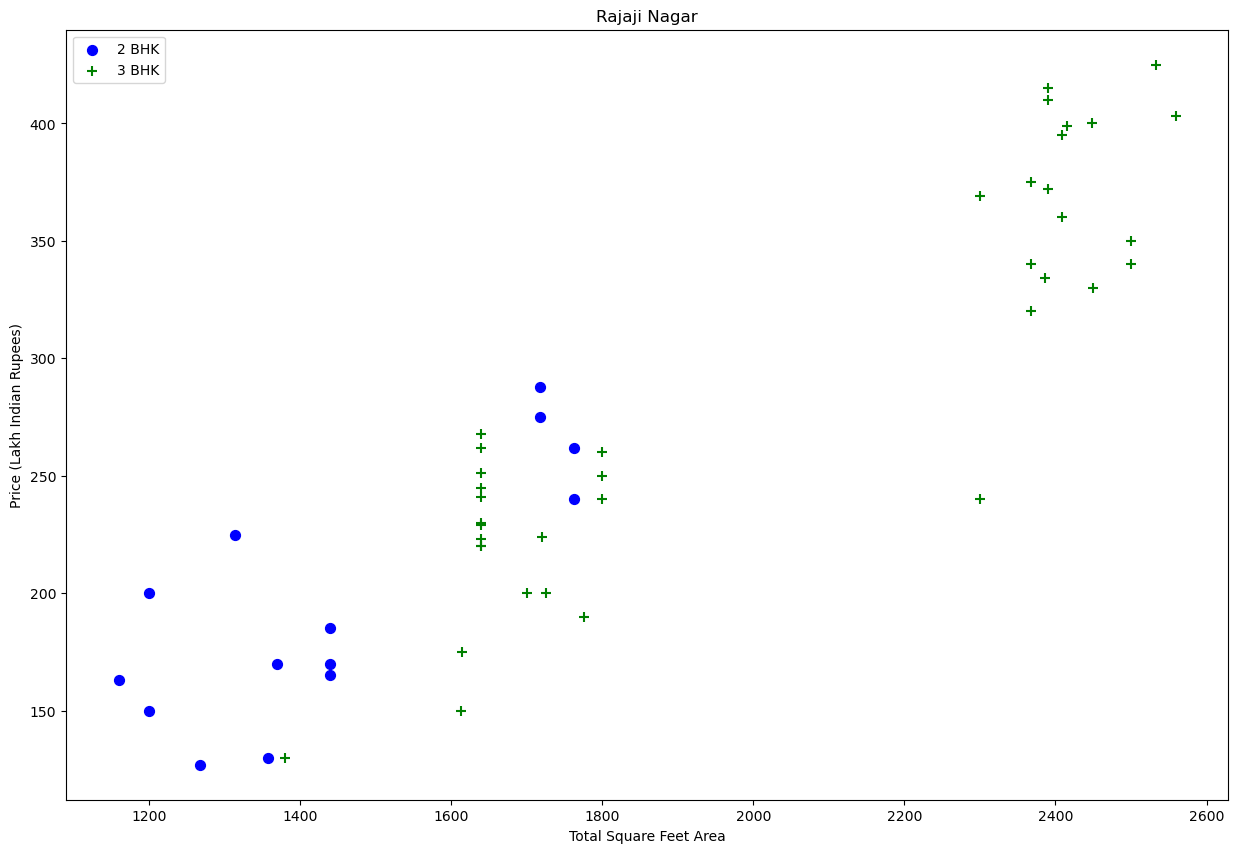

In [33]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df,"Rajaji Nagar")

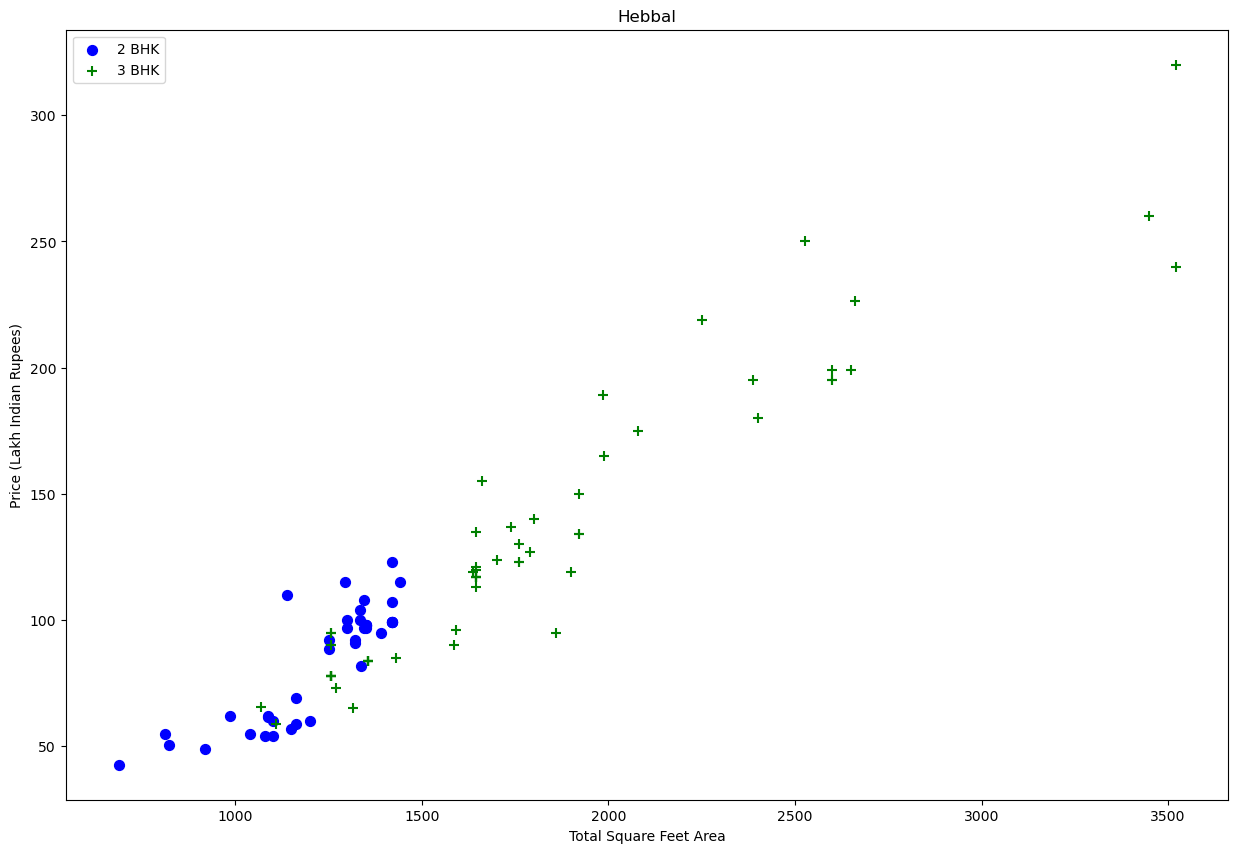

In [34]:
plot_scatter_chart(df,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [35]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df = remove_bhk_outliers(df)

df.shape

(7342, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

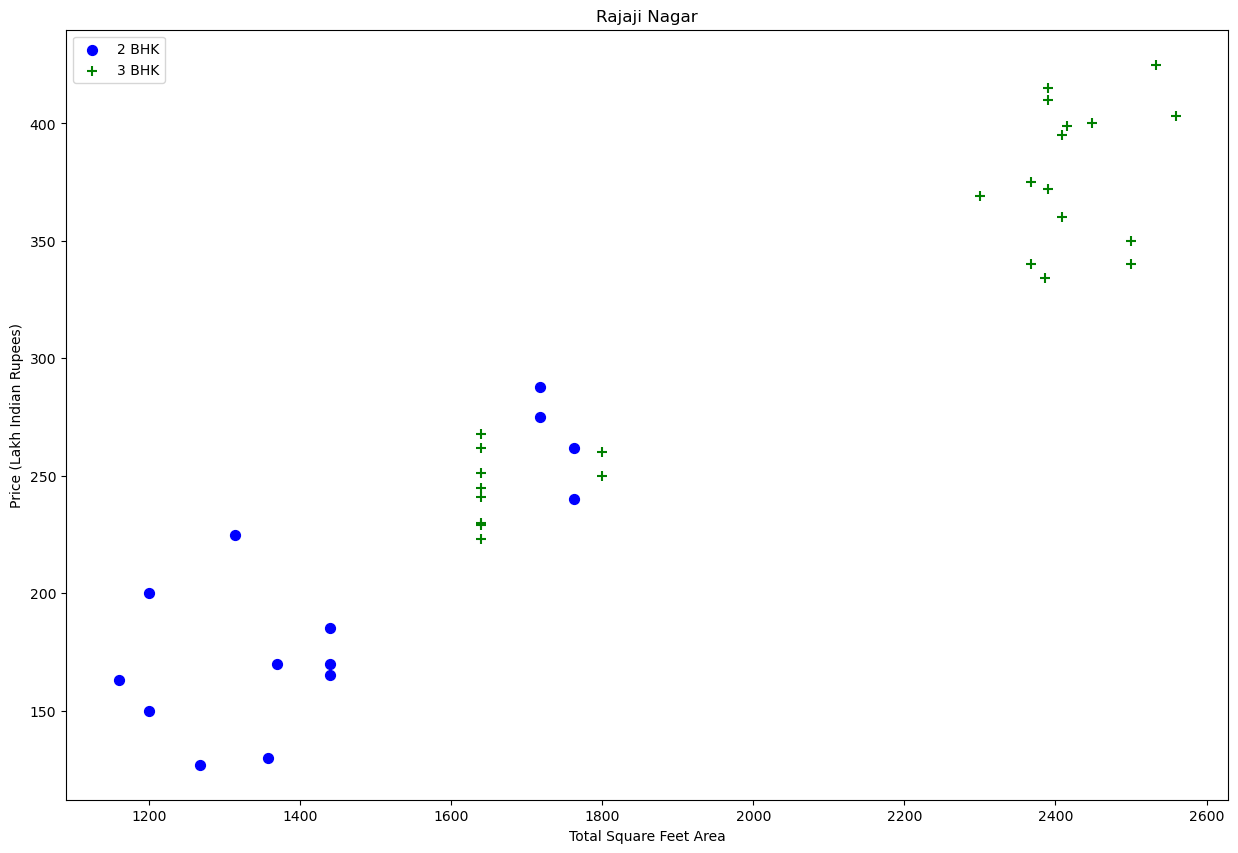

In [36]:
plot_scatter_chart(df,"Rajaji Nagar")

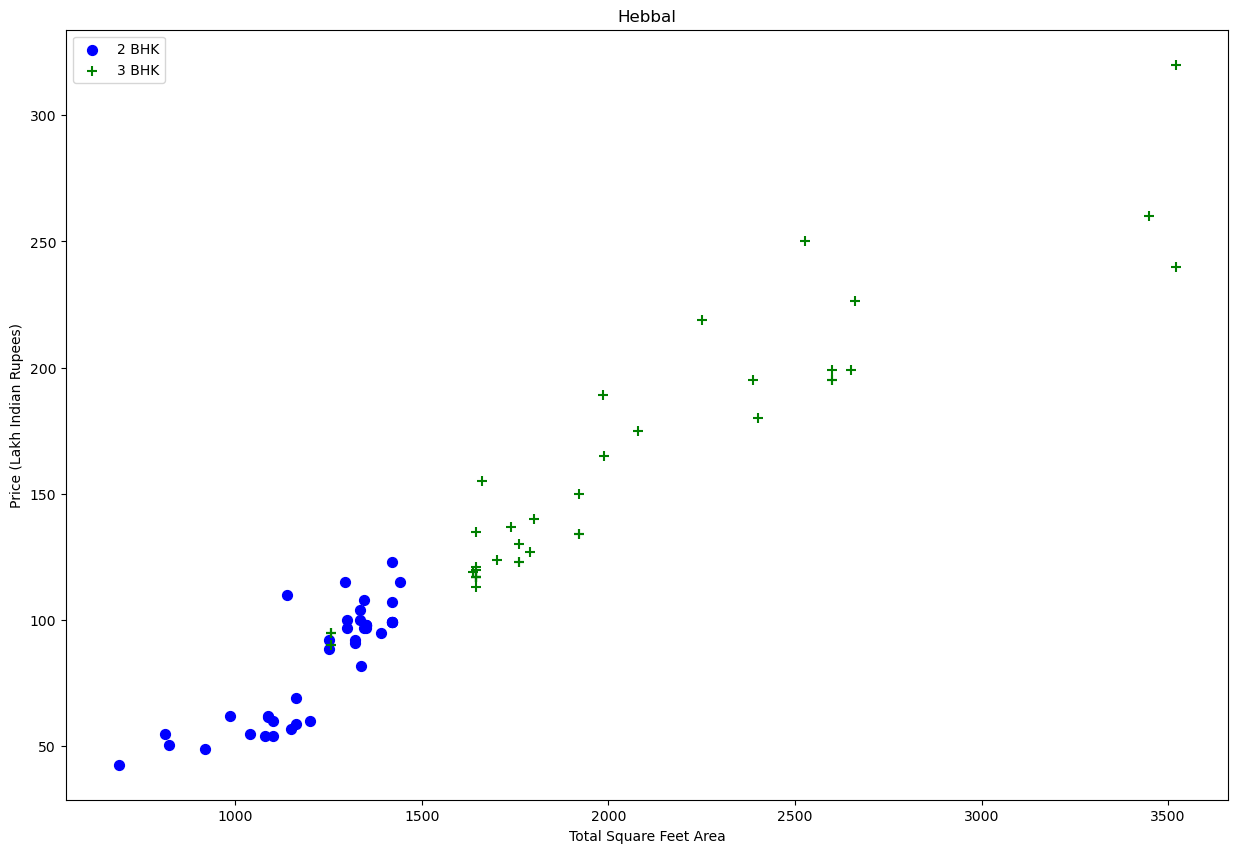

In [37]:
plot_scatter_chart(df,"Hebbal")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

<img src="rajaji_nagar_outliers.png"></img>

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

<img src="hebbal_outliers.png"></img>

Text(0, 0.5, 'Count')

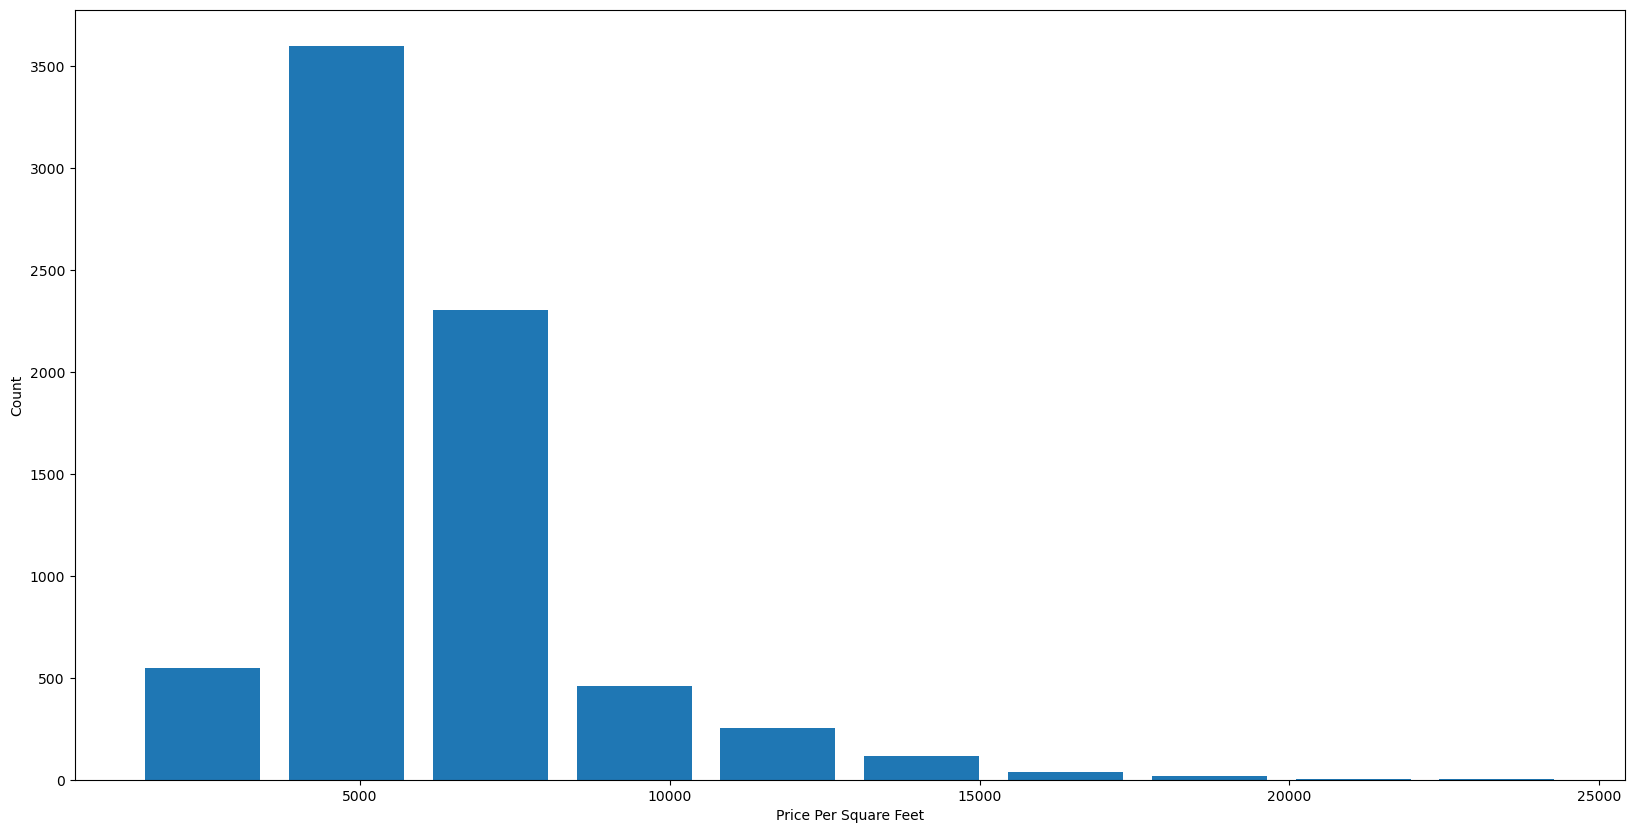

In [38]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

### Outlier Removal Using Bathrooms Feature

In [39]:
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

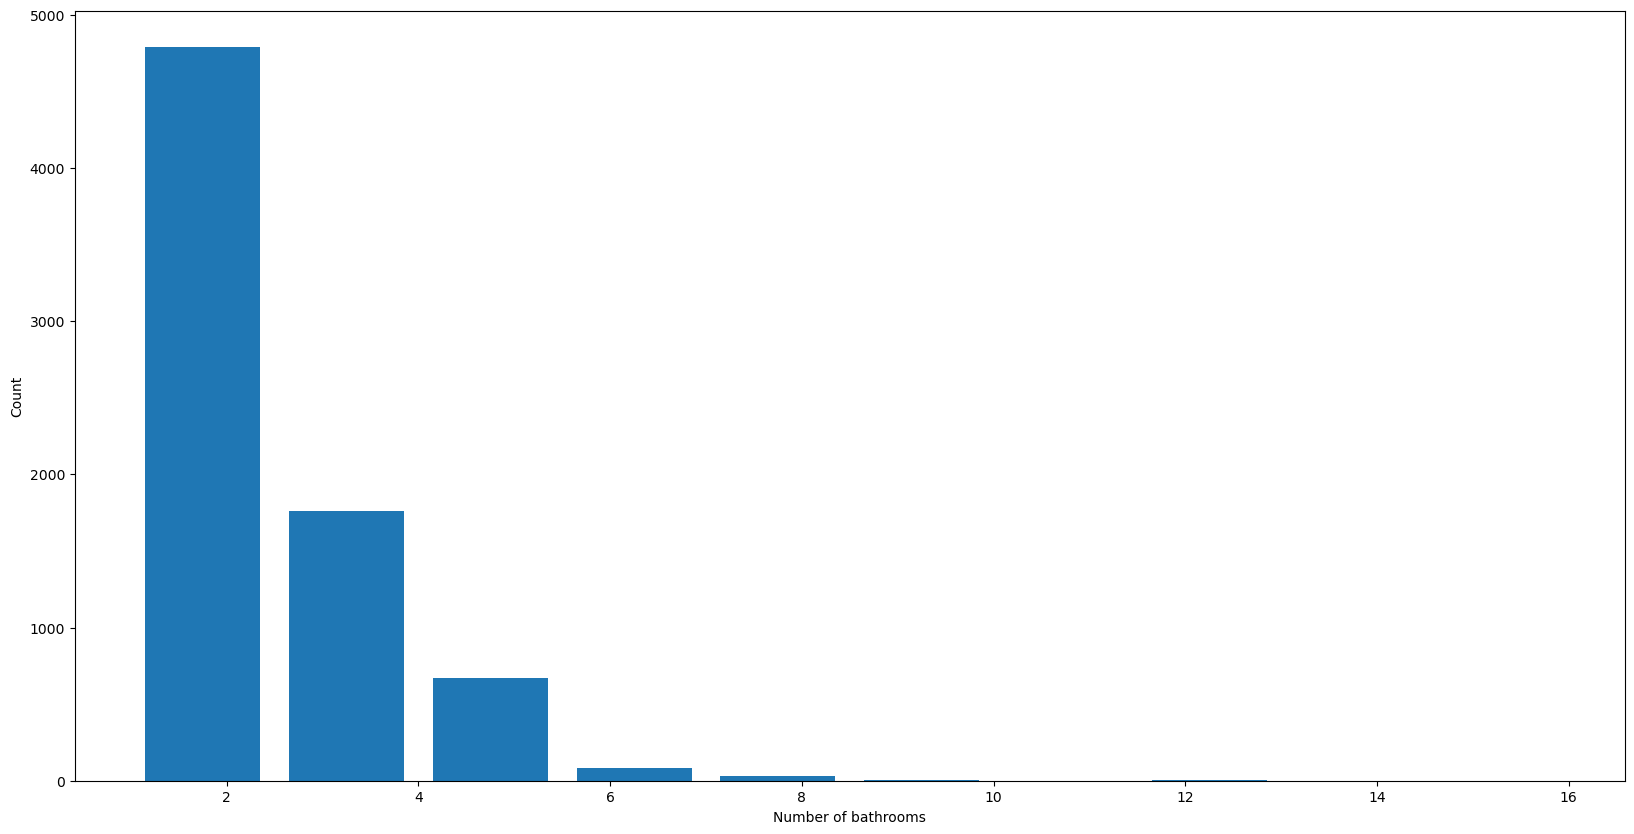

In [40]:
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [41]:
df[df.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5306,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8527,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8616,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9351,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9682,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [42]:
df[df.bath>df.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1634,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5267,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6748,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8452,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [43]:
df = df[df.bath<df.bhk+2]
df.shape

(7264, 7)

In [44]:
df.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [45]:
df = df.drop(['size','price_per_sqft'],axis='columns')
df.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [46]:
dummies = pd.get_dummies(df.location, dtype=int)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df = pd.concat([df,dummies.drop('other',axis='columns')],axis='columns')
df.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df = df.drop('location',axis='columns')
df.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Build a Model

In [49]:
df.shape

(7264, 244)

In [50]:
X = df.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
X.shape

(7264, 243)

In [52]:
y = df.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [53]:
len(y)

7264

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [55]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.858182336081298

### Use K Fold cross validation to measure accuracy of our LinearRegression model

In [56]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.80800523, 0.77206975, 0.84432393, 0.84201188, 0.82939234])

In [57]:
# average score from cross validation

np.mean(cross_val_score(LinearRegression(), X, y, cv=cv))

0.81916062568008

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

### Find best model using GridSearchCV

In [58]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'copy_X' : [True, False],
                'fit_intercept' : [True, False],
                'n_jobs' : [1,2,3],
                'positive' : [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

C:\Users\EO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\EO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\EO\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\EO\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\EO\anaconda3\Lib\site-packages\sklearn\utils\_

,model,best_score,best_params
0,linear_regression,0.819388,"{'copy_X': True, 'fit_intercept': False, 'n_jo..."
1,lasso,0.661239,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.702669,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

### Test the model for few properties

In [59]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [60]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\Users\EO\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.61715202117466

In [61]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\EO\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


87.61625225437793

In [62]:
predict_price('Indira Nagar',1000, 2, 2)

C:\Users\EO\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


185.6771364403195

In [63]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Users\EO\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


189.67623667352274

### Export the tested model to a pickle file

In [64]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

### Export location and column information to a file that will be useful later on in our prediction application

In [65]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))